In [3]:
from util.log import plot_ts_result
from util.process import MyDataset, Modeling
from util.model import Transformer, LSTM, RNN
from collections import namedtuple, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/merged_fill.csv") 
df["INNER_HMDT"] = (df["INNER_HMDT_1"] + df["INNER_HMDT_2"]) / 2
df["INNER_TPRT"] = (df["INNER_TPRT_1"] + df["INNER_TPRT_2"]) / 2


In [4]:
x_cols = ["EXTN_TPRT", "외부일사량"] #"DWP_TPRT"를 넣으면 Transformer에서 거의 100점짜리 답안이 나옴
# y_cols = ["INNER_TPRT"]
# data = MyDataset(df, x_cols, y_cols)
# train_loader, test_loader = data.preprocessing(train_ratio=0.8)

In [5]:
pred_df_train = pd.read_csv("data/pred_train.csv")
pred_df_test = pd.read_csv("data/pred_test.csv")

분류부터 딥러닝으로 설계하는 연습을 해보자


reinforcement learning 

RNN

In [28]:
MODEL_NAME = "RNN"

X = df[x_cols][:pred_df_train.shape[0]]
X["pred"] = pred_val = pred_df_train[MODEL_NAME]
y = true_val = pred_df_train["answer"]


In [5]:
# absv = np.abs(true_val-pred_val)
# unique, counts = np.unique(np.ceil(absv), return_counts=True)
# dd = dict(zip(unique, counts))
# dd

{1.0: 10570,
 2.0: 10429,
 3.0: 7963,
 4.0: 5851,
 5.0: 4769,
 6.0: 4143,
 7.0: 3340,
 8.0: 2653,
 9.0: 2082,
 10.0: 1560,
 11.0: 1224,
 12.0: 759,
 13.0: 352,
 14.0: 129,
 15.0: 36,
 16.0: 11,
 17.0: 1}

In [29]:
class GreenhouseTSEnv(gym.Env):
    def __init__(self, data, tick=3): # data is a batch
        super(GreenhouseTSEnv, self).__init__()

        self.tick = tick
        self.history = data
        self.current_step = 0
        self.nums_data, input_size = data[0].shape
        self.max_steps = self.nums_data-1

        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(input_size,))
        # Action space: Up, Hold, Down
        self.action_space = spaces.Discrete(3)
        self.actions = {0: self.tick, 1: 0, 2: -self.tick}

    def reset(self):
        self.current_step = 0
        return self.history[0][self.current_step]

    def step(self, action):
        pred = self.history[0][self.current_step][-1]
        answer = self.history[1][self.current_step]
        before_diff = abs(torch.tensor(pred) - answer)
        pred += self.actions[action]
        
        after_diff = abs(torch.tensor(pred) - answer)
        if before_diff < after_diff:
            after_diff *= 100
        reward = - after_diff

        self.current_step += 1
        observation = self.history[0][self.current_step]
        done = self.current_step > self.max_steps 

        return observation, reward, done, {"new_pred": pred}

In [30]:
# Env가 잘 만들어졌는데 실행시키는 코드
batch_size = 4

env = GreenhouseTSEnv([
    X.iloc[:batch_size].to_numpy(),
    y.iloc[:batch_size].to_numpy()
])

observation = env.reset()
for i in range(env.max_steps):
    pred = pred_val[0:32][i]
    action = env.action_space.sample()  # Random action for now
    observation, reward, done, _ = env.step(action)
    print(action, observation, reward, done)
    if done:
        print("done")
        break


0 [19.55       64.225      20.21079063] tensor(-7.1445, dtype=torch.float64) False
1 [19.3        64.45       21.97317696] tensor(-5.5892, dtype=torch.float64) False
2 [19.7        65.675      23.66376114] tensor(-655.1823, dtype=torch.float64) False


In [31]:


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network for Q-function approximation
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple(
            "Experience", field_names=["state", "action", "reward", "next_state", "done"]
        )

    def append(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(DEVICE)  # GPU로 이동
        actions = torch.LongTensor(np.array([e.action for e in batch])).to(DEVICE)  # GPU로 이동
        rewards = torch.FloatTensor(np.array([e.reward for e in batch])).to(DEVICE)  # GPU로 이동
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(DEVICE)  # GPU로 이동
        dones = torch.BoolTensor(np.array([e.done for e in batch])).to(DEVICE)  # GPU로 이동
        return states, actions, rewards, next_states, dones

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=32, gamma=0.99, lr=1e-3, update_freq=4, target_update_freq=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_freq = update_freq
        self.target_update_freq = target_update_freq
        self.q_network = DQN(state_size, action_size).to(DEVICE)  # GPU로 이동
        self.target_network = DQN(state_size, action_size).to(DEVICE)  # GPU로 이동
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.steps = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)  # GPU로 이동
            q_values = self.q_network(state)
            return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

In [34]:
@dataclass
class Epsilon:
    current: float = 1.0 # start value
    final: float = 0.1
    decay: float = 0.995

MOVING_AVERAGE_WINDOW = 10
def log_train(episode, episode_rewards, current_epsilon):
    print(f"Episode: {episode}, Reward: {episode_rewards[-1].item()}, Epsilon: {current_epsilon}")
    plt.plot(episode_rewards)
    moving_average = np.convolve(
        episode_rewards, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
    plt.plot(np.arange(MOVING_AVERAGE_WINDOW-1, len(episode_rewards)), 
            moving_average, label=f'{MOVING_AVERAGE_WINDOW}-Times Moving Average', 
            color='red')
    plt.savefig(f"rewards_{MODEL_NAME}.png")

def main_train(env, agent, epsilons, max_episodes):
    episode_rewards = []
    for episode in range(1, max_episodes + 1):
        state = env.reset()
        episode_reward = 0
        for _ in range(env.max_steps): # max_steps_per_episode
            action = agent.select_action(state, epsilons.current)
            next_state, reward, done, _ = env.step(action)
            reward = reward/env.nums_data
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            episode_reward += reward
            if done:
                break
        epsilons.current = max(epsilons.final, epsilons.current * epsilons.decay)
        episode_rewards.append(episode_reward)
        if episode % 50 == 0:
            log_train(episode, episode_rewards, epsilons.current)

window_size = 2000
env = GreenhouseTSEnv([
        X.iloc[:window_size].to_numpy(),
        y.iloc[:window_size].to_numpy(),
    ], tick=3
)

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

epsilons = Epsilon()
max_episodes = 500

main_train(env, agent, epsilons, max_episodes)

Episode: 50, Reward: -202.78353634185754, Epsilon: 0.778312557068642
Episode: 100, Reward: -144.4437775382996, Epsilon: 0.6057704364907278
Episode: 150, Reward: -117.94829788646695, Epsilon: 0.47147873742168567
Episode: 200, Reward: -93.71129107913966, Epsilon: 0.3669578217261671
Episode: 250, Reward: -77.34220037498483, Epsilon: 0.285607880564032
Episode: 300, Reward: -65.34606223545076, Epsilon: 0.22229219984074702
Episode: 350, Reward: -45.5627648450851, Epsilon: 0.1730128104744653


Episode: 50, Reward: -81.3965190702438, Epsilon: 0.34731301240586104
Episode: 100, Reward: -85.78609025306686, Epsilon: 0.33036609214652046
Episode: 150, Reward: -82.58565642738334, Epsilon: 0.31424608621522926
Episode: 200, Reward: -81.26130282649997, Epsilon: 0.2989126458468155
Episode: 250, Reward: -77.99385638561249, Epsilon: 0.284327391068757
Episode: 300, Reward: -74.31712856864928, Epsilon: 0.27045381463518003
Episode: 350, Reward: -74.02623207321165, Epsilon: 0.25725719064833996
Episode: 400, Reward: -63.27590915622712, Epsilon: 0.24470448763885772
Episode: 450, Reward: -62.02903830509192, Epsilon: 0.23276428588715223
Episode: 500, Reward: -62.946228754615824, Epsilon: 0.22140669877912197
Episode: 550, Reward: -54.90764456272129, Epsilon: 0.21060329799922556
Episode: 600, Reward: -54.595833318138105, Epsilon: 0.20032704237371998
Episode: 650, Reward: -58.33532155647278, Epsilon: 0.1905522101859476
Episode: 700, Reward: -46.508325009346, Epsilon: 0.18125433479425698
Episode: 750

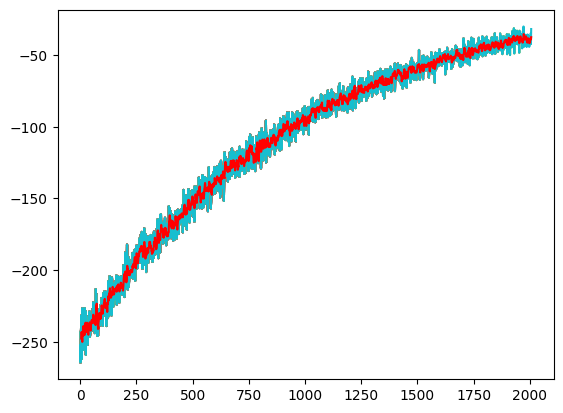

In [11]:

for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(env.max_steps): # max_steps_per_episode
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilons.final, epsilon * epsilons.decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
        print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
        plt.plot(episode_rewards)
        moving_average = np.convolve(
            episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
        plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
                moving_average, label=f'{moving_average_window}-Times Moving Average', 
                color='red')
        plt.savefig("rewards_LSTM.png")
        if epsilon == epsilons.final:
            break
    


Episode: 50, Reward: -37.0796728622436, Epsilon: 0.12770540562505597
Episode: 100, Reward: -29.997016862678493, Epsilon: 0.12147410058173808
Episode: 150, Reward: -27.4783460233688, Epsilon: 0.11554684815352155
Episode: 200, Reward: -26.269551164817763, Epsilon: 0.10990881228405747
Episode: 250, Reward: -31.1372200988769, Epsilon: 0.10454588083304645
Episode: 300, Reward: -27.40567340621943, Epsilon: 0.0994446302532099
Episode: 350, Reward: -29.24662214202879, Epsilon: 0.09459229199082606
Episode: 400, Reward: -34.7146014572143, Epsilon: 0.08997672052573072
Episode: 450, Reward: -22.570274577140772, Epsilon: 0.0855863629707864
Episode: 500, Reward: -22.661921698379487, Epsilon: 0.08141023015472601
Episode: 550, Reward: -18.35636198596955, Epsilon: 0.07743786911599104
Episode: 600, Reward: -18.502580454063406, Epsilon: 0.07365933693871574
Episode: 650, Reward: -15.459748647880547, Epsilon: 0.07006517586536791
Episode: 700, Reward: -20.180323711204522, Epsilon: 0.06664638962375281
Episod

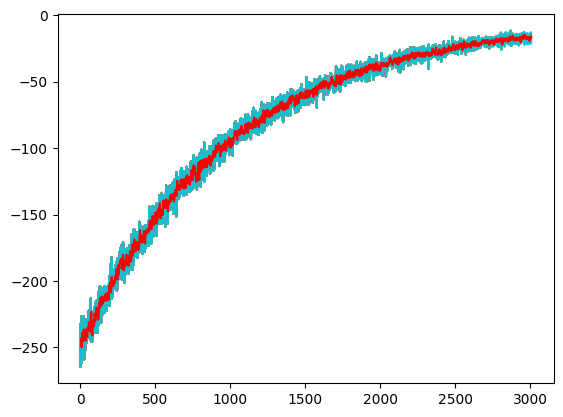

In [12]:

for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
        print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
        plt.plot(episode_rewards)
        moving_average = np.convolve(
            episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
        plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
                moving_average, label=f'{moving_average_window}-Times Moving Average', 
                color='red')
        plt.savefig("rewards_LSTM.png")
        if epsilon == epsilon_final:
            break
    


In [27]:
torch.save(agent.q_network, 'q_model.pth')
torch.save(agent.target_network, 'target_model.pth')


In [ ]:
# new_agent = torch.load('model.pth')


In [18]:
from util.log import regression_results
# true_val, pred_val = modeling.eval(test_loader, data.y_test)
# batch_size = 32
# X = df[x_cols][-len(test_loader)*batch_size:]
# y = df[y_cols][-len(test_loader)*batch_size:]
# X["pred"] = pred_val

MODEL_NAME = "RNN"

X = df[x_cols][-pred_df_test.shape[0]:]
X["pred"] = pred_val = pred_df_test[MODEL_NAME]
y = true_val = pred_df_test["answer"]
true_val.shape, pred_val.shape

((13952,), (13952,))

In [22]:
X.shape, y.shape

((13952, 3), (13952,))

In [19]:


env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
], tick=3)

new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

In [21]:
for step in range(env.max_steps):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
new_pred_val

IndexError: index 13952 is out of bounds for axis 0 with size 13952

In [20]:



# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val,new_pred_val)
plot_ts_result(new_pred_val, pred_val)

ValueError: Input contains NaN.

ValueError: Input contains NaN.

Episode: 50, Reward: -183.0145950673289, Epsilon: 0.9512056281970315
Episode: 100, Reward: -178.55508346965786, Epsilon: 0.9047921471137096
Episode: 150, Reward: -164.87596405029277, Epsilon: 0.8606433826830369
Episode: 200, Reward: -157.87180963878632, Epsilon: 0.818648829478636
Episode: 250, Reward: -156.2543920374677, Epsilon: 0.7787033741169904
Episode: 300, Reward: -138.57684457485178, Epsilon: 0.7407070321560997
Episode: 350, Reward: -143.20351535282094, Epsilon: 0.704564697832001
Episode: 400, Reward: -130.67308004795046, Epsilon: 0.6701859060067403
Episode: 450, Reward: -124.4172299669646, Epsilon: 0.6374846057319378
Episode: 500, Reward: -112.62781596652968, Epsilon: 0.6063789448611848
Episode: 550, Reward: -117.93240593921645, Epsilon: 0.5767910651721362
Episode: 600, Reward: -108.06171996692647, Epsilon: 0.5486469074854965
Episode: 650, Reward: -107.90782014461492, Epsilon: 0.5218760262931003
Episode: 700, Reward: -98.14409419094063, Epsilon: 0.4964114134310989
Episode: 750,

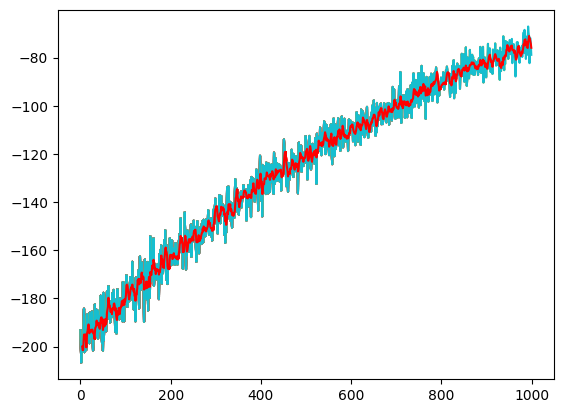

In [14]:
# with GPU: 22 min
window_size = 2000

temp = X.iloc[:window_size]
env = GreenhouseTSEnv([
    temp.to_numpy(),
    y.iloc[:window_size].to_numpy(),
],
tick=3
)

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.999
max_episodes = 1000
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_LSTM2.png")


explained_variance:  0.8358
r2:  0.8047
MAE:  1.8331
MSE:  4.8768
RMSE:  2.2084
explained_variance:  0.816
r2:  0.7861
MAE:  1.8833
MSE:  5.3423
RMSE:  2.3113


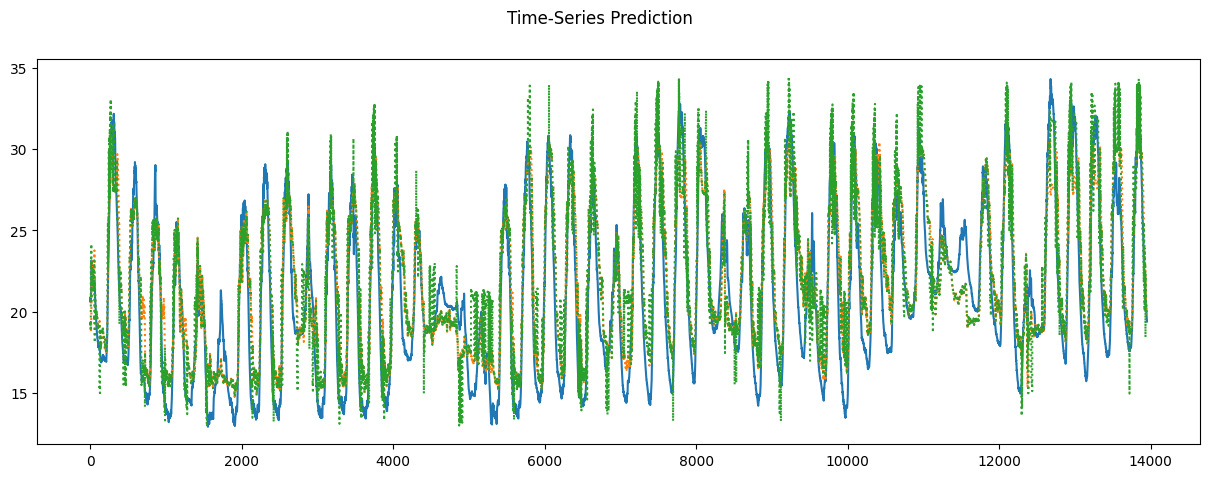

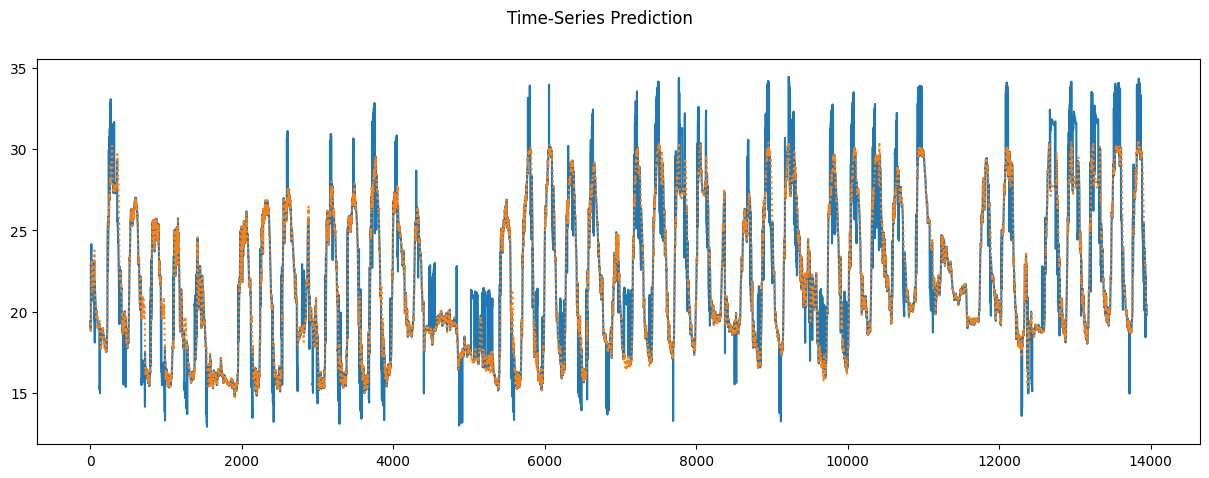

In [15]:
from util.log import regression_results
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val,new_pred_val)
plot_ts_result(new_pred_val, pred_val)

Episode: 50, Reward: -44.21929239974981, Epsilon: 0.01
Episode: 100, Reward: -40.72457011817928, Epsilon: 0.01
Episode: 150, Reward: -34.384172174682455, Epsilon: 0.01
Episode: 200, Reward: -36.112135644149625, Epsilon: 0.01
Episode: 250, Reward: -34.96196850044234, Epsilon: 0.01
Episode: 300, Reward: -36.45683331054678, Epsilon: 0.01
Episode: 350, Reward: -38.95344334537492, Epsilon: 0.01


KeyboardInterrupt: 

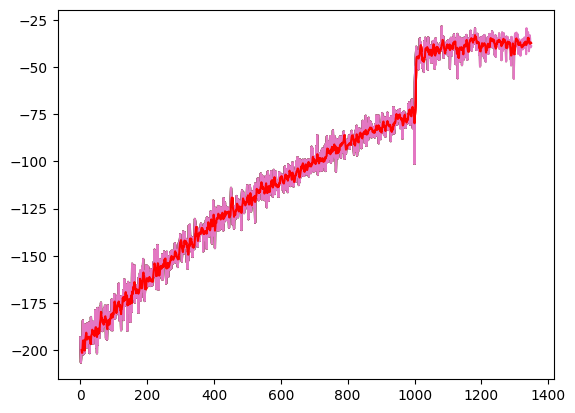

In [16]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_LSTM.png")

explained_variance:  0.8358
r2:  0.8047
MAE:  1.8331
MSE:  4.8768
RMSE:  2.2084
explained_variance:  0.8359
r2:  0.8053
MAE:  1.8286
MSE:  4.8608
RMSE:  2.2047


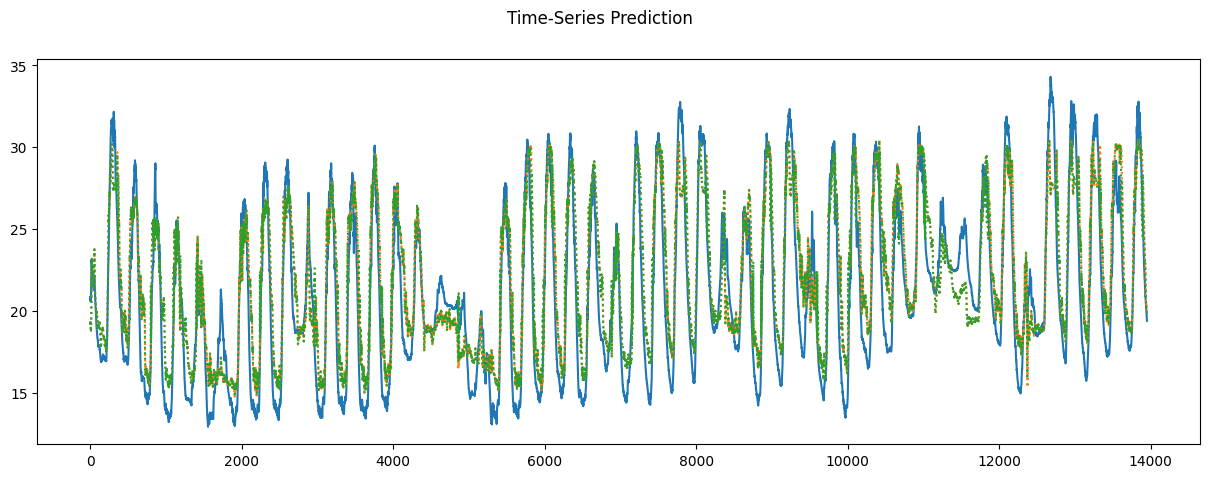

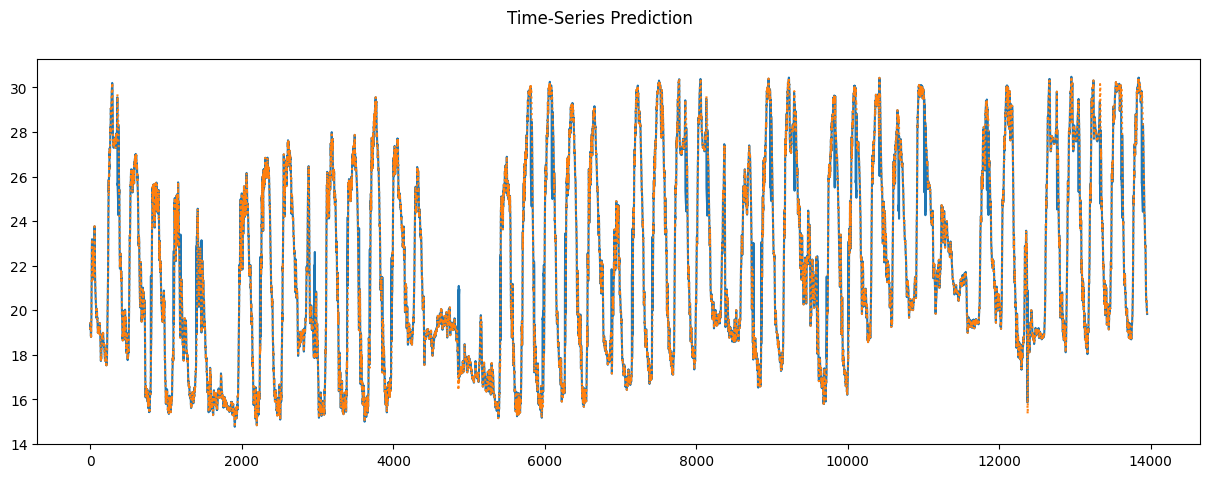

In [17]:
from util.log import regression_results
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val,new_pred_val)
plot_ts_result(new_pred_val, pred_val)

RL Feedback With Transformer 

Episode: 50, Reward: -248.3108439784049, Epsilon: 0.9512056281970315
Episode: 100, Reward: -230.02802852315907, Epsilon: 0.9047921471137096
Episode: 150, Reward: -222.66170951013555, Epsilon: 0.8606433826830369
Episode: 200, Reward: -213.24463635768902, Epsilon: 0.818648829478636
Episode: 250, Reward: -196.15011966419198, Epsilon: 0.7787033741169904
Episode: 300, Reward: -195.0820155509949, Epsilon: 0.7407070321560997
Episode: 350, Reward: -176.7588825073241, Epsilon: 0.704564697832001
Episode: 400, Reward: -160.02389142303468, Epsilon: 0.6701859060067403
Episode: 450, Reward: -144.1980123898505, Epsilon: 0.6374846057319378
Episode: 500, Reward: -156.0718756016729, Epsilon: 0.6063789448611848
Episode: 550, Reward: -142.16869624938943, Epsilon: 0.5767910651721362
Episode: 600, Reward: -133.98096340570453, Epsilon: 0.5486469074854965
Episode: 650, Reward: -123.87612494964591, Epsilon: 0.5218760262931003
Episode: 700, Reward: -139.43272307415, Epsilon: 0.4964114134310989
Episode: 750, Rew

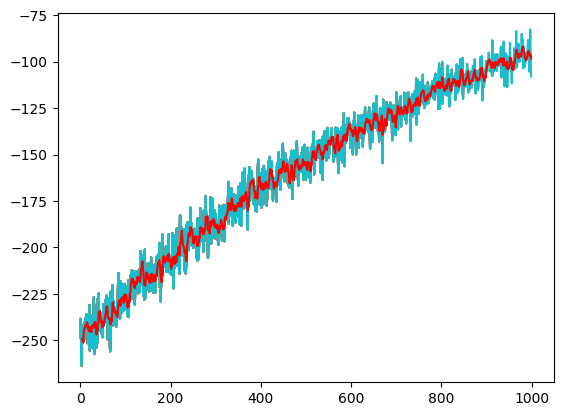

In [48]:
window_size = 2000

temp = X.iloc[:window_size]
env = GreenhouseTSEnv([
    temp.to_numpy(),
    y.iloc[:window_size].to_numpy(),
],
tick=3
)

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.999
max_episodes = 1000
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha_explore_new_reward.png")


explained_variance:  0.745
r2:  0.7361
MAE:  2.0735
MSE:  6.5887
RMSE:  2.5668
explained_variance:  0.8008
r2:  0.6868
MAE:  2.2696
MSE:  7.8212
RMSE:  2.7966


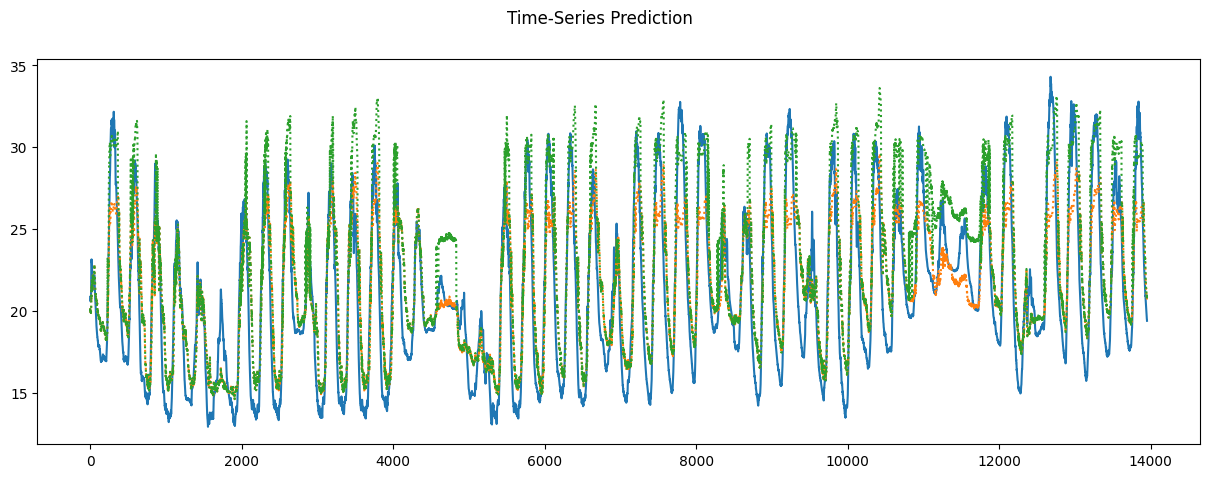

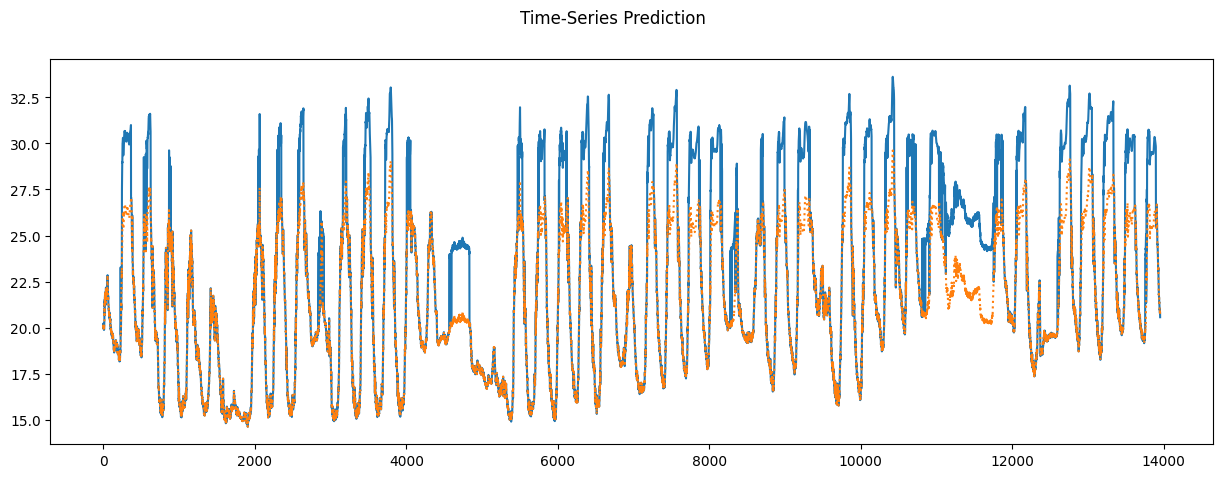

In [49]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val,new_pred_val)
plot_ts_result(new_pred_val, pred_val)

Episode: 50, Reward: -35.02680447830207, Epsilon: 0.01
Episode: 100, Reward: -38.679609385700445, Epsilon: 0.01
Episode: 150, Reward: -35.170526000385465, Epsilon: 0.01


KeyboardInterrupt: 

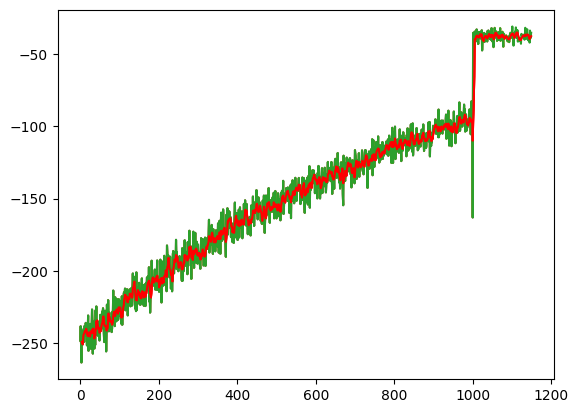

In [50]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha_explore_new_reward.png")

In [53]:
torch.save(agent.q_network, 'q_model.pth')
torch.save(agent.target_network, 'target_model.pth')


explained_variance:  0.745
r2:  0.7361
MAE:  2.0735
MSE:  6.5887
RMSE:  2.5668
explained_variance:  0.8076
r2:  0.8003
MAE:  1.8402
MSE:  4.9873
RMSE:  2.2332


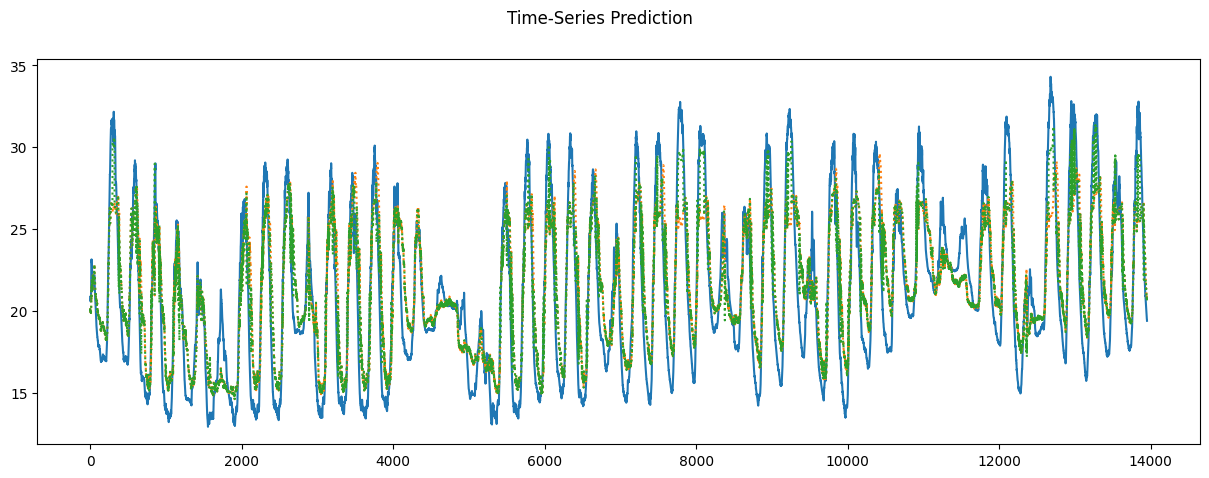

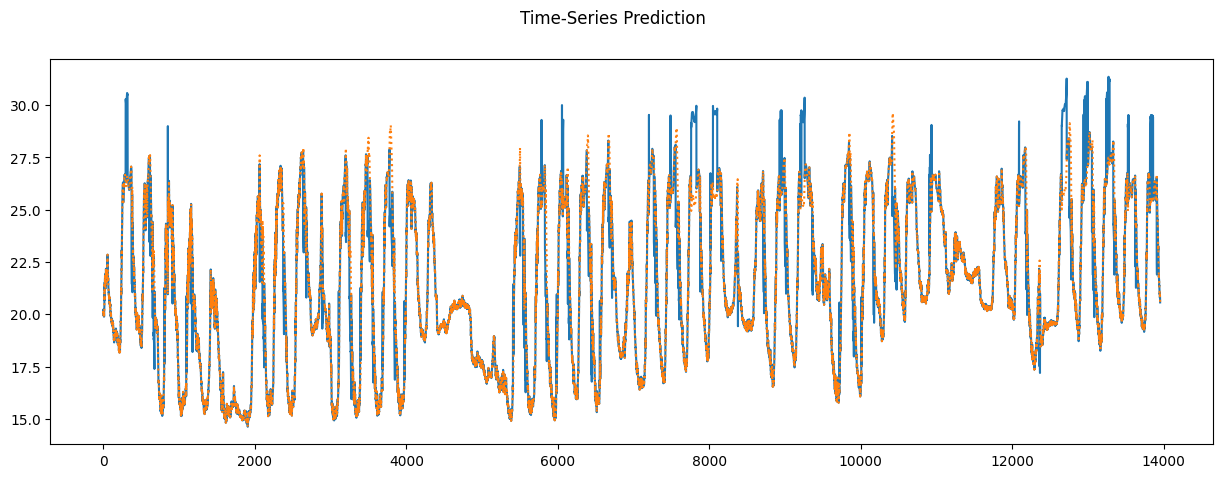

In [51]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val[:new_batch], new_pred_val)

plot_ts_result(true_val[:new_batch], pred_val[:new_batch],new_pred_val)
plot_ts_result(new_pred_val, pred_val)

explained_variance:  -0.6745
r2:  -0.6777
MAE:  3.8316
MSE:  24.3085
RMSE:  4.9304
explained_variance:  -0.6935
r2:  -0.6971
MAE:  3.874
MSE:  24.5893
RMSE:  4.9588


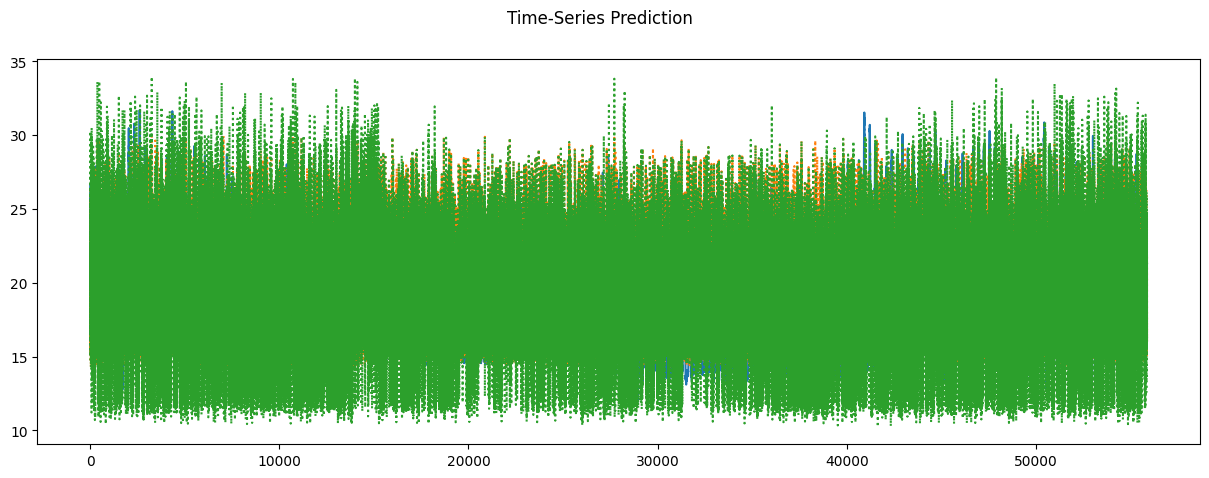

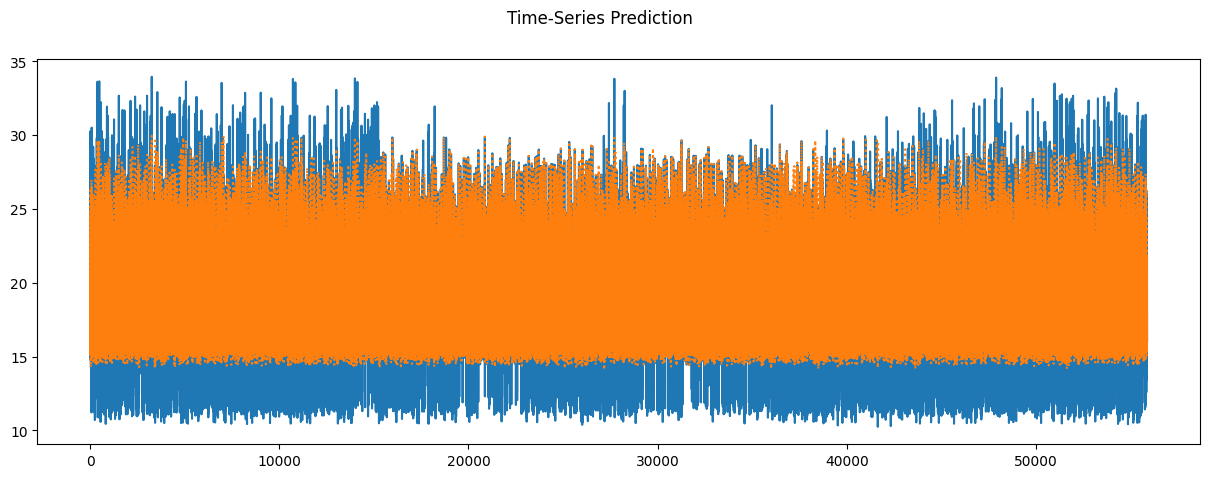

In [52]:
true_val, pred_val = modeling.eval(train_loader, data.y_train)
batch_size = 32
X = df[x_cols][:len(train_loader)*batch_size]
y = df[y_cols][:len(train_loader)*batch_size]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])

max_steps_per_episode = new_batch = len(train_loader)*batch_size
# env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val, new_pred_val)
plot_ts_result(new_pred_val, pred_val)